# P5 - Convolutioneel neuraal netwerk

## Richard Jansen 1762581

![](https://cdn.discordapp.com/attachments/808321877193916456/821681363957841930/unknown.png)

# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random

from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers

from sklearn.model_selection import train_test_split

import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

# Data Exploration

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


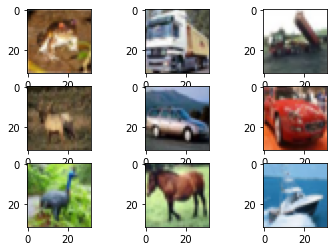

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i])
pyplot.show()

In [3]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [4]:
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


# Data Augmenttation

In [5]:
# Bereik / maximale waardes van de aanpassingen specificeren
rotation_range_val = 15
width_shift_val = 0.15
height_shift_val = 0.15
shear_range_val = 25
zoom_range_val = [0.9,1.1]
fill_mode_val = "wrap"


# Combineren in een ImageDataGenerator object
datagen = ImageDataGenerator(rotation_range = rotation_range_val,
                             width_shift_range = width_shift_val,
                             height_shift_range = height_shift_val,
                             fill_mode = fill_mode_val,
                             rescale = 1/255,
                             zoom_range=zoom_range_val)

In [6]:
datagen.fit(X_test)

X_test_augmented, Y_test_augmented = next(datagen.flow(X_test, y_test, batch_size=X_test.shape[0], shuffle=False))

Test: X=(10000, 32, 32, 3), y=(10000, 10)


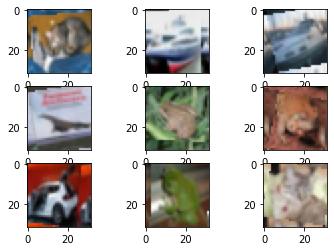

In [7]:
print('Test: X=%s, y=%s' % (X_test_augmented.shape, Y_test_augmented.shape))

for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow((X_test_augmented[i] * 255).astype(np.uint8))
pyplot.show()

# Analyse

De data bestaad dus uit een plaatjes van **32x32 met 3 kleur kanalen**, dit is belangrijke informatie om uiteindelijk filter grote te bepalen en hoeveel filters.

Merk op dat hierboven de plaatjes ook op rand staan dus er moet ook gebruik gemaakt worden van **Zero padding**

## Filter grote keuze en layer opbouw

### Input layer
Voor de eerste layer is het logish om dan 32 filters te nemen met een grote van 3x3 (3x3 is een normaal gebruikte grote Voor dit soort cnn oplossingen). 

Voor de activatie methode maak ik gebruik van de relu activatie, uit verschilende testen kwam deze met het hoogste resultaat.

Na de activatie maak ik gebruik van BatchNormalization, in het algemeen is dit toepasbaar voor elke layer voor een robuust netwerk.

Na het normaliseren maak ik gebruik van maxpooling om de image te verkleinen en "algemene" waardens te krijgen, hierdoor wordt de output van deze laag verkleint naar 16x16x3.

Elke layer geef ik een dropout mee maar bij de eerste layer is het beter om niet een te grote waarde op tegeven want dit is immers je input van het model. Daarom is de dropout hier 0.2.

### Tussen layers

Belangrijke note voor mijn gedachte gang, ik wil maximaal 3 layers voor de output hebben zitten ivm kleur channels
Het zou tof zijn als het netwerk in de eerste/2d laag kleuren zou herkennen en groeperen en de 2 lagen erna vormen gaat herkennen met de toenamen in aantals filters door filters x 2 tedoen voor elke laag.

Voor elk volgende layer die ik toevoeg worden een aantal dingen continue hergebruikt zoals;

**Activatie = relu**

**BatchNormalization**

**Maxpooling 2x2**

De filter grote wordt per laag met x2 vergroot in de hoop dat het steeds meer verschillende dingen kan combineren van de voorgaande input.

De dropout verhoog ik met elke laag met 0.1 omdat er ook meer filters worden gebruikt en eigenlijk dus ook mogelijk een hoop duplicaat filers.

### Output laag

Aan het einde van het netwerk flatten ik de outkomst en zorg ervoor dat het netwerk dezelfde uitkomst grote heeft als de target, in dit geval doe **10** classes.

De activatie functie is hier dan ook softmax om de juiste keuze te maken, 1 uitkomst*.


# Maken modelen

# Baseline Model \ /

In [8]:
model_baseline =Sequential()
# Input layer
model_baseline.add(Conv2D(filters = 32, kernel_size =(3,3), input_shape=(32, 32, 3)))
model_baseline.add(Activation('relu'))
model_baseline.add(MaxPooling2D(pool_size=(2,2)))

# 2e layer
model_baseline.add(Conv2D(filters = 32, kernel_size =(3,3)))
model_baseline.add(Activation('relu'))
model_baseline.add(MaxPooling2D(pool_size=(2,2)))

model_baseline.add(Flatten())
model_baseline.add(Dense(10, activation='softmax'))

In [9]:
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

# Fancy model \ /

In [10]:
model_fancy = Sequential()
# Input layer
model_fancy.add(Conv2D(filters = 32, kernel_size =(3,3), padding='same', input_shape=(32, 32, 3)))
model_fancy.add(Activation('relu'))
model_fancy.add(BatchNormalization())
model_fancy.add(MaxPooling2D(pool_size=(2,2)))
model_fancy.add(Dropout(0.2))

# 2e layer
model_fancy.add(Conv2D(filters = 64, kernel_size = (3,3), padding='same'))
model_fancy.add(Activation('relu'))
model_fancy.add(BatchNormalization())
model_fancy.add(MaxPooling2D(pool_size=(2,2)))
model_fancy.add(Dropout(0.3))

# 3e Layer
model_fancy.add(Conv2D(filters = 128, kernel_size = (3,3), padding='same'))
model_fancy.add(Activation('relu'))
model_fancy.add(BatchNormalization())
model_fancy.add(MaxPooling2D(pool_size=(2,2)))
model_fancy.add(Dropout(0.4))

model_fancy.add(Flatten())
model_fancy.add(Dense(10, activation='softmax'))

In [11]:
model_fancy.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 16, 16, 64)       

# Copy Fancy model voor augmented test \ /

In [12]:
model_fancy_aug = Sequential()
# Input layer
model_fancy_aug.add(Conv2D(filters = 32, kernel_size =(3,3), padding='same', input_shape=(32, 32, 3)))
model_fancy_aug.add(Activation('relu'))
model_fancy_aug.add(BatchNormalization())
model_fancy_aug.add(MaxPooling2D(pool_size=(2,2)))
model_fancy_aug.add(Dropout(0.2))

# 2e layer
model_fancy_aug.add(Conv2D(filters = 64, kernel_size = (3,3), padding='same'))
model_fancy_aug.add(Activation('relu'))
model_fancy_aug.add(BatchNormalization())
model_fancy_aug.add(MaxPooling2D(pool_size=(2,2)))
model_fancy_aug.add(Dropout(0.3))

# 3e Layer
model_fancy_aug.add(Conv2D(filters = 128, kernel_size = (3,3), padding='same'))
model_fancy_aug.add(Activation('relu'))
model_fancy_aug.add(BatchNormalization())
model_fancy_aug.add(MaxPooling2D(pool_size=(2,2)))
model_fancy_aug.add(Dropout(0.4))

model_fancy_aug.add(Flatten())
model_fancy_aug.add(Dense(10, activation='softmax'))

In [13]:
model_fancy_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 64)       

# Compiler argumenten
Voor het compilen heb ik verschillenden optimizers gebruikt maar er zit bijna/geen verschillen tussen alle adam optimizers of varianten er van

ik heb ook andere geprobeerd maar die preseteren nog slechter

Het zelfde gelt voor de loss argument

## Compile baseline \ /

In [14]:
model_baseline.compile(loss="categorical_crossentropy",metrics=["accuracy"])

# Compile fancy model \ /

In [15]:
model_fancy.compile(loss="categorical_crossentropy", optimizer= 'adam', metrics=["accuracy"])

# Compile fancy model Augmented\ /

In [16]:
model_fancy_aug.compile(loss="categorical_crossentropy", optimizer= 'adam', metrics=["accuracy"])

# Train models

## Train baseline

In [17]:
history_baseline  = model_baseline.fit(X_train, y_train, batch_size=64, epochs=75, validation_split=0.1)

Epoch 1/75
704/704 [==============================] - 5s 6ms/step - loss: 3.9451 - accuracy: 0.1101 - val_loss: 2.2731 - val_accuracy: 0.1300
Epoch 2/75
704/704 [==============================] - 3s 4ms/step - loss: 2.2789 - accuracy: 0.1333 - val_loss: 3.2048 - val_accuracy: 0.2196
Epoch 3/75
704/704 [==============================] - 3s 5ms/step - loss: 2.1532 - accuracy: 0.2467 - val_loss: 1.9622 - val_accuracy: 0.3056
Epoch 4/75
704/704 [==============================] - 3s 4ms/step - loss: 1.7479 - accuracy: 0.3827 - val_loss: 2.2518 - val_accuracy: 0.3538
Epoch 5/75
704/704 [==============================] - 3s 4ms/step - loss: 1.5323 - accuracy: 0.4531 - val_loss: 1.8147 - val_accuracy: 0.3998
Epoch 6/75
704/704 [==============================] - 3s 4ms/step - loss: 1.4142 - accuracy: 0.5086 - val_loss: 1.5999 - val_accuracy: 0.4704
Epoch 7/75
704/704 [==============================] - 3s 4ms/step - loss: 1.3333 - accuracy: 0.5352 - val_loss: 2.1981 - val_accuracy: 0.3268
Epoch 

704/704 [==============================] - 3s 4ms/step - loss: 1.2673 - accuracy: 0.5859 - val_loss: 1.7308 - val_accuracy: 0.5346
Epoch 59/75
704/704 [==============================] - 3s 4ms/step - loss: 1.2747 - accuracy: 0.5818 - val_loss: 1.5511 - val_accuracy: 0.5432
Epoch 60/75
704/704 [==============================] - 3s 4ms/step - loss: 1.2644 - accuracy: 0.5834 - val_loss: 2.2773 - val_accuracy: 0.4132
Epoch 61/75
704/704 [==============================] - 3s 4ms/step - loss: 1.2816 - accuracy: 0.5790 - val_loss: 2.2740 - val_accuracy: 0.3982
Epoch 62/75
704/704 [==============================] - 3s 4ms/step - loss: 1.2733 - accuracy: 0.5808 - val_loss: 1.8774 - val_accuracy: 0.4770
Epoch 63/75
704/704 [==============================] - 3s 4ms/step - loss: 1.2784 - accuracy: 0.5803 - val_loss: 1.7115 - val_accuracy: 0.4766
Epoch 64/75
704/704 [==============================] - 3s 4ms/step - loss: 1.2748 - accuracy: 0.5811 - val_loss: 1.5077 - val_accuracy: 0.5596
Epoch 65/75

## Train Fancy model 

In [18]:
history_fancy  = model_fancy.fit(X_train, y_train, batch_size=64, epochs=75, validation_split=0.1)

Epoch 1/75
704/704 [==============================] - 5s 7ms/step - loss: 2.3833 - accuracy: 0.3488 - val_loss: 1.2258 - val_accuracy: 0.5752
Epoch 2/75
704/704 [==============================] - 4s 6ms/step - loss: 1.3527 - accuracy: 0.5452 - val_loss: 1.2215 - val_accuracy: 0.5748
Epoch 3/75
704/704 [==============================] - 4s 6ms/step - loss: 1.1197 - accuracy: 0.6120 - val_loss: 1.3683 - val_accuracy: 0.5516
Epoch 4/75
704/704 [==============================] - 4s 6ms/step - loss: 1.0349 - accuracy: 0.6413 - val_loss: 1.0025 - val_accuracy: 0.6606
Epoch 5/75
704/704 [==============================] - 4s 6ms/step - loss: 0.9253 - accuracy: 0.6776 - val_loss: 1.1928 - val_accuracy: 0.5956
Epoch 6/75
704/704 [==============================] - 4s 6ms/step - loss: 0.8823 - accuracy: 0.6929 - val_loss: 0.8412 - val_accuracy: 0.7024
Epoch 7/75
704/704 [==============================] - 4s 6ms/step - loss: 0.8289 - accuracy: 0.7117 - val_loss: 0.9596 - val_accuracy: 0.6706
Epoch 

704/704 [==============================] - 4s 6ms/step - loss: 0.4678 - accuracy: 0.8334 - val_loss: 0.6751 - val_accuracy: 0.7794
Epoch 59/75
704/704 [==============================] - 4s 6ms/step - loss: 0.4712 - accuracy: 0.8312 - val_loss: 0.5216 - val_accuracy: 0.8206
Epoch 60/75
704/704 [==============================] - 4s 6ms/step - loss: 0.4732 - accuracy: 0.8309 - val_loss: 0.5267 - val_accuracy: 0.8198
Epoch 61/75
704/704 [==============================] - 4s 6ms/step - loss: 0.4702 - accuracy: 0.8338 - val_loss: 0.6027 - val_accuracy: 0.8012
Epoch 62/75
704/704 [==============================] - 4s 6ms/step - loss: 0.4725 - accuracy: 0.8336 - val_loss: 0.5818 - val_accuracy: 0.7994
Epoch 63/75
704/704 [==============================] - 4s 6ms/step - loss: 0.4741 - accuracy: 0.8311 - val_loss: 0.9517 - val_accuracy: 0.7206
Epoch 64/75
704/704 [==============================] - 4s 6ms/step - loss: 0.4671 - accuracy: 0.8325 - val_loss: 0.5241 - val_accuracy: 0.8212
Epoch 65/75

## Train Fancy model Augmented

In [19]:
history_fancy_aug  = model_fancy_aug.fit(X_test_augmented, Y_test_augmented, batch_size=64, epochs=75, validation_split=0.1)

Epoch 1/75
141/141 [==============================] - 1s 8ms/step - loss: 3.2722 - accuracy: 0.2130 - val_loss: 2.6133 - val_accuracy: 0.1090
Epoch 2/75
141/141 [==============================] - 1s 6ms/step - loss: 2.2567 - accuracy: 0.3205 - val_loss: 2.7617 - val_accuracy: 0.1240
Epoch 3/75
141/141 [==============================] - 1s 6ms/step - loss: 1.9602 - accuracy: 0.3644 - val_loss: 2.2876 - val_accuracy: 0.1850
Epoch 4/75
141/141 [==============================] - 1s 6ms/step - loss: 1.7892 - accuracy: 0.4016 - val_loss: 1.8490 - val_accuracy: 0.3640
Epoch 5/75
141/141 [==============================] - 1s 6ms/step - loss: 1.6772 - accuracy: 0.4334 - val_loss: 1.6539 - val_accuracy: 0.4070
Epoch 6/75
141/141 [==============================] - 1s 7ms/step - loss: 1.6290 - accuracy: 0.4490 - val_loss: 1.5578 - val_accuracy: 0.4390
Epoch 7/75
141/141 [==============================] - 1s 7ms/step - loss: 1.5425 - accuracy: 0.4606 - val_loss: 1.6030 - val_accuracy: 0.4360
Epoch 

141/141 [==============================] - 1s 6ms/step - loss: 0.5505 - accuracy: 0.7975 - val_loss: 1.5753 - val_accuracy: 0.5300
Epoch 59/75
141/141 [==============================] - 1s 6ms/step - loss: 0.5718 - accuracy: 0.7908 - val_loss: 1.3617 - val_accuracy: 0.5880
Epoch 60/75
141/141 [==============================] - 1s 6ms/step - loss: 0.5359 - accuracy: 0.8040 - val_loss: 1.2831 - val_accuracy: 0.5990
Epoch 61/75
141/141 [==============================] - 1s 6ms/step - loss: 0.5427 - accuracy: 0.8108 - val_loss: 1.4304 - val_accuracy: 0.5450
Epoch 62/75
141/141 [==============================] - 1s 6ms/step - loss: 0.5424 - accuracy: 0.7998 - val_loss: 1.5251 - val_accuracy: 0.5740
Epoch 63/75
141/141 [==============================] - 1s 6ms/step - loss: 0.5280 - accuracy: 0.8069 - val_loss: 1.3424 - val_accuracy: 0.5840
Epoch 64/75
141/141 [==============================] - 1s 6ms/step - loss: 0.5481 - accuracy: 0.8047 - val_loss: 1.3557 - val_accuracy: 0.5790
Epoch 65/75

# Evaluatie baseline

In [20]:
loss, accuracy = model_baseline.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.7450 - accuracy: 0.4837
Test loss: 1.7450
Test accuracy: 0.4837


In [21]:
# score X_test_augmented
score = model_baseline.evaluate(X_test_augmented, Y_test_augmented)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 4.0144 - accuracy: 0.1068
Test score: 4.014378070831299
Test accuracy: 0.10679999738931656


# plotting

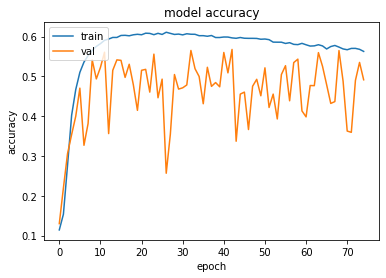

In [22]:
plt.plot(history_baseline.history['accuracy'])
plt.plot(history_baseline.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

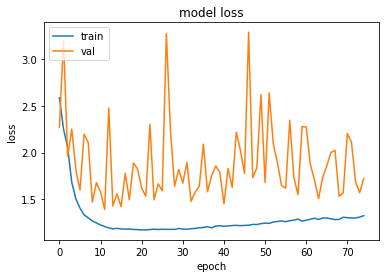

In [23]:
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluatie Fancy Model

In [24]:
loss, accuracy = model_fancy.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.6655 - accuracy: 0.7782
Test loss: 0.6655
Test accuracy: 0.7782


In [25]:
# score X_test_augmented
score = model_fancy.evaluate(X_test_augmented, Y_test_augmented)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 3.2098 - accuracy: 0.1000
Test score: 3.2098493576049805
Test accuracy: 0.10000000149011612


# plotting

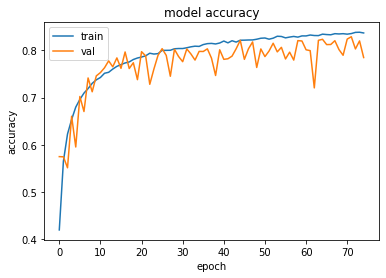

In [26]:
plt.plot(history_fancy.history['accuracy'])
plt.plot(history_fancy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

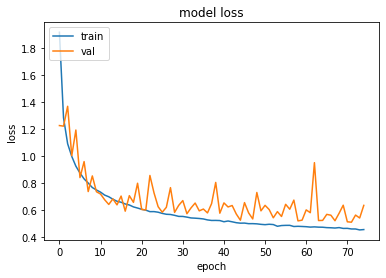

In [27]:
plt.plot(history_fancy.history['loss'])
plt.plot(history_fancy.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluatie Fancy Augmented Model

In [28]:
loss, accuracy = model_fancy_aug.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 128.2074 - accuracy: 0.4099
Test loss: 128.2074
Test accuracy: 0.4099


# plotting

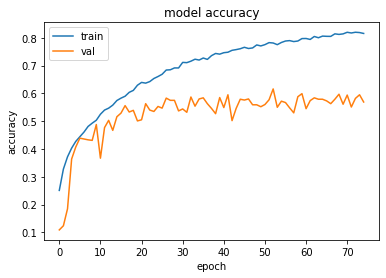

In [30]:
plt.plot(history_fancy_aug.history['accuracy'])
plt.plot(history_fancy_aug.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

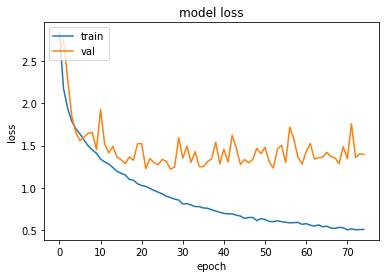

In [31]:
plt.plot(history_fancy_aug.history['loss'])
plt.plot(history_fancy_aug.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Conclusie

In dit document heb ik 3 modellen gemaakt. De eerste 2 modellen heb ik vergeleken met een test set en een aangepaste (“Augmented”) set waarvan de plaatjes gedraaid/gestretcht/ingezoomd zijn. Deze twee modellen zijn ook allebei getraind op een normale train set

### Stats Baseline
Score op test set = ~ 48%
Score op augmented test set = ~10%

### Stats Fancy Model
Score op test set = ~ 78%
Score op augmented test set = ~10%

### Stats Fancy Augmented Model
Score op test set = ~ 40%

## laatste Gedachten

Een model trainen op een augmented data set heeft niet zo heel veel zin zoals hierboven zichtbaar is. Mijn uitgebreide model is relatief makkelijk opgebouwd en behaald een goede scoren.
